In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import axis as ax
import tikzplotlib
from tqdm import tqdm
import time

Peut on utiliser les données des votes pour avoir une representation graphique de la position des candidats, et des participants ?

# 1. En utilisant les déclarations des participants

Dans certains jeux de données, il est demandé aux candidats de se placer eux mêmes sur un axe gauche droite, quelle distribution des participants obtient on alors ?



## 1.A. 2017 - Online

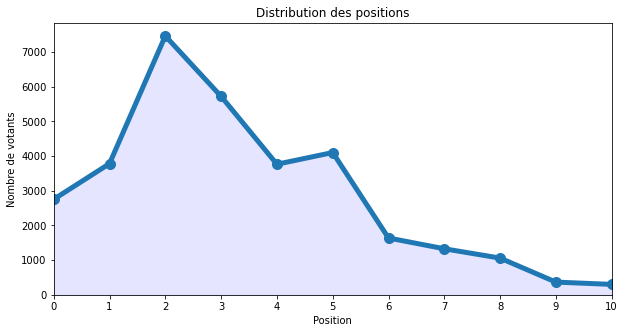

In [2]:
voters_online = pd.read_csv('../Voter Autrement - 2017 - Online/voters.csv')
positions = voters_online['position'].to_numpy()
distrib = np.zeros(11)
for x in positions:
    if not pd.isna(x):
        distrib[int(x)] += 1

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_title('Distribution des positions')
ax.set_xlabel('Position')
ax.set_ylabel('Nombre de votants')
ax.set_xticks(range(11))
# ax.set_xticklabels(['Très à gauche', 'Plutôt à gauche', 'Légèrement à gauche', 'Centre', 'Légèrement à droite', 'Plutôt à droite', 'Très à droite', 'Extrême gauche', 'Extrême droite', 'Autre', 'Ne se prononce pas'])
plt.plot(range(11), distrib, 'o-', linewidth=5, markersize=10)
plt.fill_between(range(11), distrib, color='blue', alpha=0.1)
plt.xlim(0,10)
plt.ylim(0)
plt.show()

On observe tout de même un fort biais à gauche. Que trouve t-on si on utilise les poids des participants

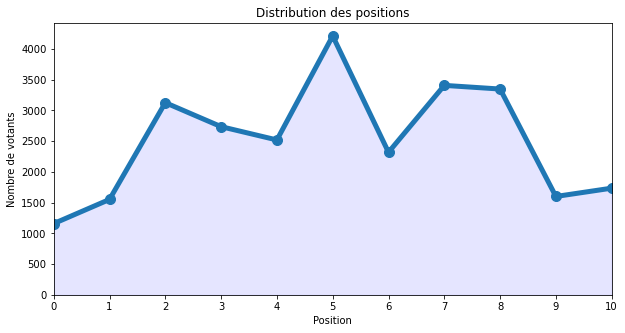

In [6]:
weights = pd.read_csv('../Voter Autrement - 2017 - Online/weights.csv', index_col=0)
positions = voters_online[['id','position']].to_numpy()
w = weights["notes"].to_dict()
distrib = np.zeros(11)
for x in positions:
    if not pd.isna(x[1]):
        distrib[int(x[1])] += w[x[0]]

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_title('Distribution des positions')
ax.set_xlabel('Position')
ax.set_ylabel('Nombre de votants')
ax.set_xticks(range(11))
# ax.set_xticklabels(['Très à gauche', 'Plutôt à gauche', 'Légèrement à gauche', 'Centre', 'Légèrement à droite', 'Plutôt à droite', 'Très à droite', 'Extrême gauche', 'Extrême droite', 'Autre', 'Ne se prononce pas'])
plt.plot(range(11), distrib, 'o-', linewidth=5, markersize=10)
plt.fill_between(range(11), distrib, color='blue', alpha=0.1)
plt.xlim(0,10)
plt.ylim(0)
plt.show()

C'est tout de suite plus fidèle à l'idée qu'on peut se faire de la réalité.

Maintenant, on peut trouver la position moyenne des candidats selon leur électeurs. Par exemple, en prenant les intentions de votes à l'élection.

In [7]:
candidates = pd.read_csv('../Voter Autrement - 2017 - Online/candidates.csv', index_col=1)
candidates = candidates.to_dict()["colors"]
candidates 

{'Nicolas Dupont-Aignan': '#0082C4',
 'Marine Le Pen': '#0D378A',
 'Emmanuel Macron': '#FFD600',
 'Benoît Hamon': '#FF8080',
 'Nathalie Arthaud': '#AA0000',
 'Philippe Poutou': '#bb0000',
 'Jacques Cheminade': '#e0dcad',
 'Jean Lassalle': '#26c4ec',
 'Jean-Luc Mélenchon': '#cc2443',
 'François Asselineau': '#9ad6af',
 'François Fillon': '#0066CC'}

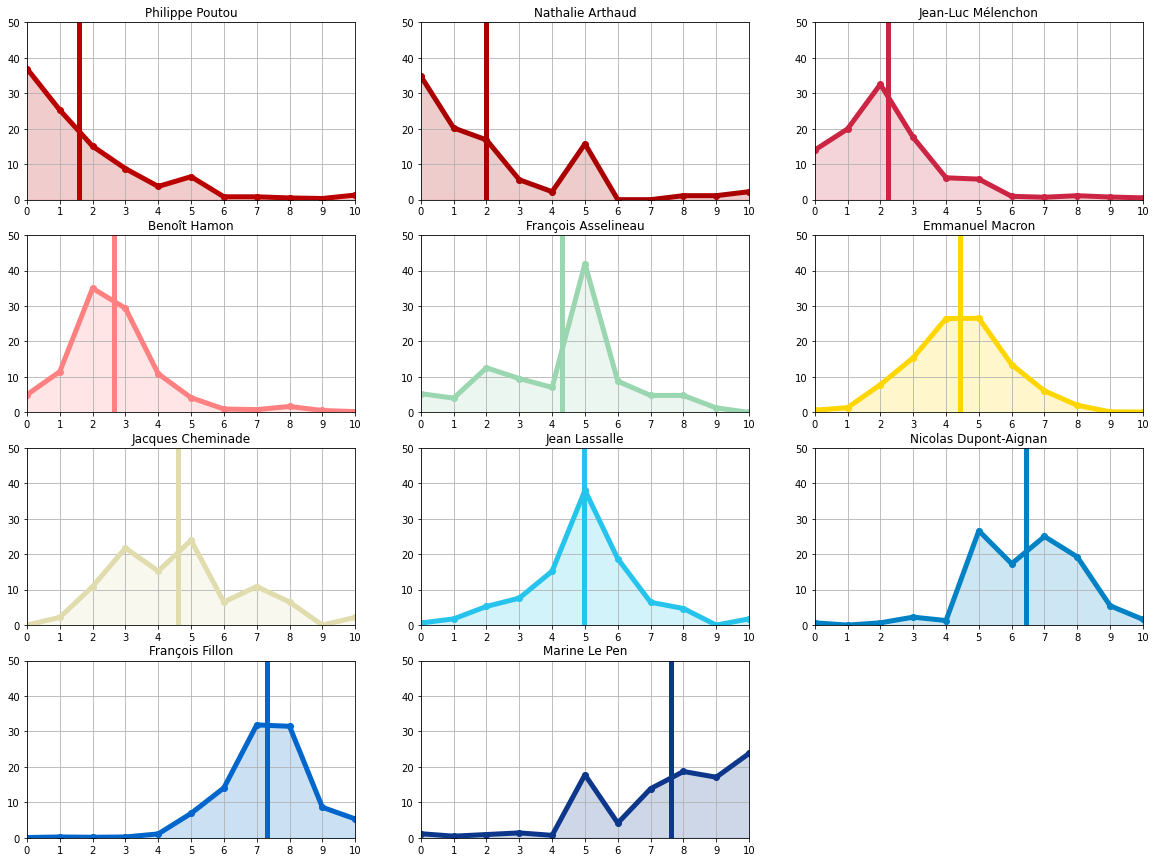

In [8]:


dict_candidates = {}
for c in candidates:
    dict_candidates[c] = np.zeros(11)
positions = voters_online[['id','position','official_vote']].to_numpy()
for x in positions:
    if not pd.isna(x[1]):
        if x[2] in candidates:
            dict_candidates[x[2]][int(x[1])] += 1


fig = plt.figure(figsize=(20,15))
mean = [np.sum([dict_candidates[c][i]*i for i in range(11)])/np.sum([dict_candidates[c][i] for i in range(11)]) for c in dict_candidates]
order = np.argsort(mean)
cand_list = [list(dict_candidates.keys())[i] for i in order]

for i, key in enumerate(cand_list):
    # subfigure 
    ax = fig.add_subplot(4, 3, cand_list.index(key)+1)
    ax.set_title(key)
    ax.set_ylim([0,50])
    ax.set_xlim([0,10])
    ax.set_xticks(range(11))
    ax.set_xticklabels(range(11))
    ax.set_yticks(range(0,51,10))
    ax.set_yticklabels(range(0,51,10))
    ax.grid(True)
    ax.plot(range(11), dict_candidates[key]*100/sum(dict_candidates[key]), "o-", color=candidates[key], linewidth=5)
    # area between 
    ax.fill_between(range(11), dict_candidates[key]*100/sum(dict_candidates[key]), color=candidates[key], alpha=0.2)
    # dark line for mean
    ax.plot([mean[order[i]], mean[order[i]]], [0, 50], color=candidates[key], linewidth=5)
plt.show()


On peut aussi regarder le pourcentage d'approbation de chaque candidat selon la position du participant

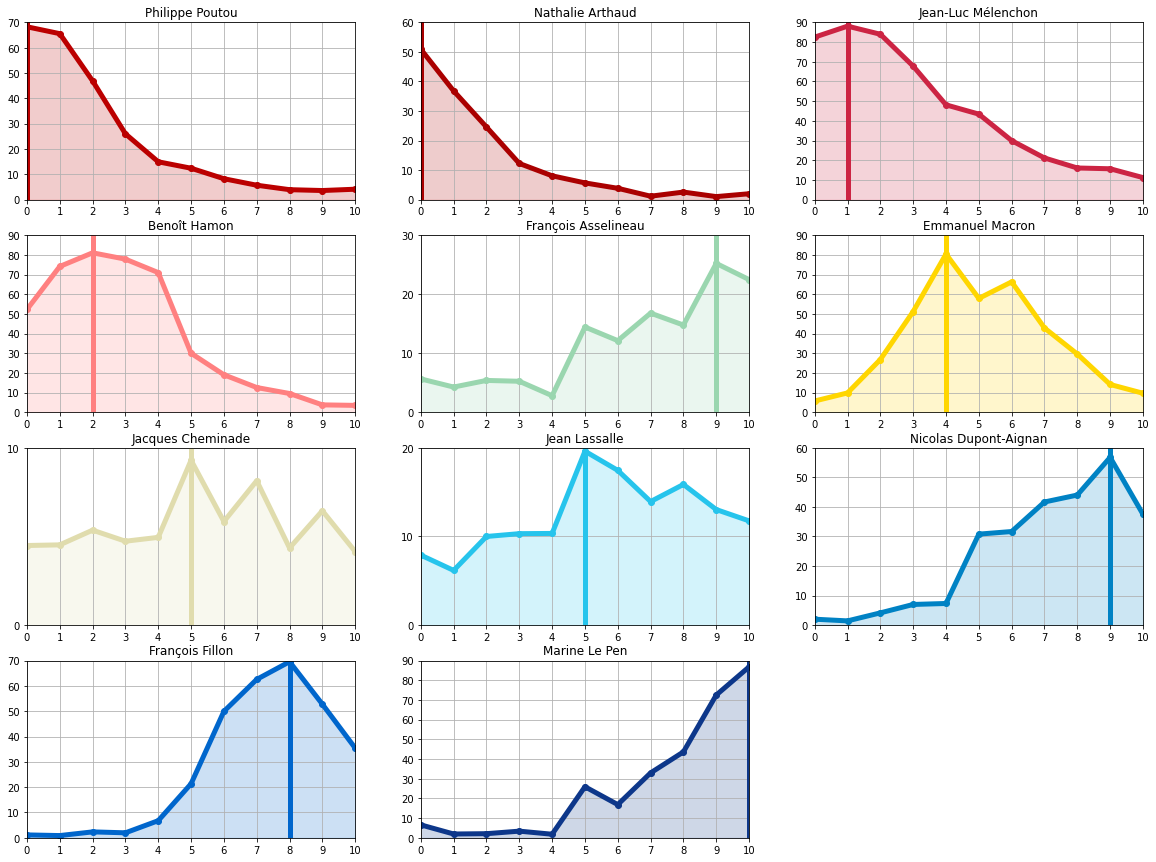

In [9]:
approval  = pd.read_csv('../Voter Autrement - 2017 - Online/votes/approval.csv')
candidates_app = list(approval.columns[1:])
approval = approval.to_numpy()
positions = voters_online[['id','position']].to_numpy()
dict_positions = {}
for x in positions:
    if not pd.isna(x[1]):
        dict_positions[x[0]] = int(x[1])

dict_candidates = {}
for c in candidates:
    dict_candidates[c] = np.zeros(11)
dict_candidates["total"] = np.zeros(11)

for x in approval:
    if x[0] not in dict_positions:
        continue
    pos = int(dict_positions[x[0]])
    for i, c in enumerate(candidates):
        if x[i+1] == 1:
            dict_candidates[candidates_app[i]][pos] += w[x[0]]
    dict_candidates["total"][pos] += w[x[0]]

fig = plt.figure(figsize=(20,15))

for i, key in enumerate(cand_list):
    # subfigure 
    ax = fig.add_subplot(4, 3, cand_list.index(key)+1)
    max_pct = min(100, int(max(dict_candidates[key]*100/dict_candidates["total"])/10)*10+10)
    ax.set_title(key)
    ax.set_ylim([0,max_pct])
    ax.set_xlim([0,10])
    ax.set_xticks(range(11))
    ax.set_xticklabels(range(11))
    ax.set_yticks(range(0,max_pct+1,10))
    ax.set_yticklabels(range(0,max_pct+1,10))
    ax.grid(True)
    ax.plot(range(11), dict_candidates[key]*100/dict_candidates["total"], "o-", color=candidates[key], linewidth=5)
    # area between 
    ax.fill_between(range(11), dict_candidates[key]*100/dict_candidates["total"], color=candidates[key], alpha=0.2)
    # dark line for best position 
    best_score = np.argmax(dict_candidates[key]*100/dict_candidates["total"])
    ax.plot([best_score, best_score], [0, max_pct], color=candidates[key], linewidth=5)

Enfin, on peut faire la même analyse avec les notes ("opinions") sur 100 plutot que les taux d'approbation:

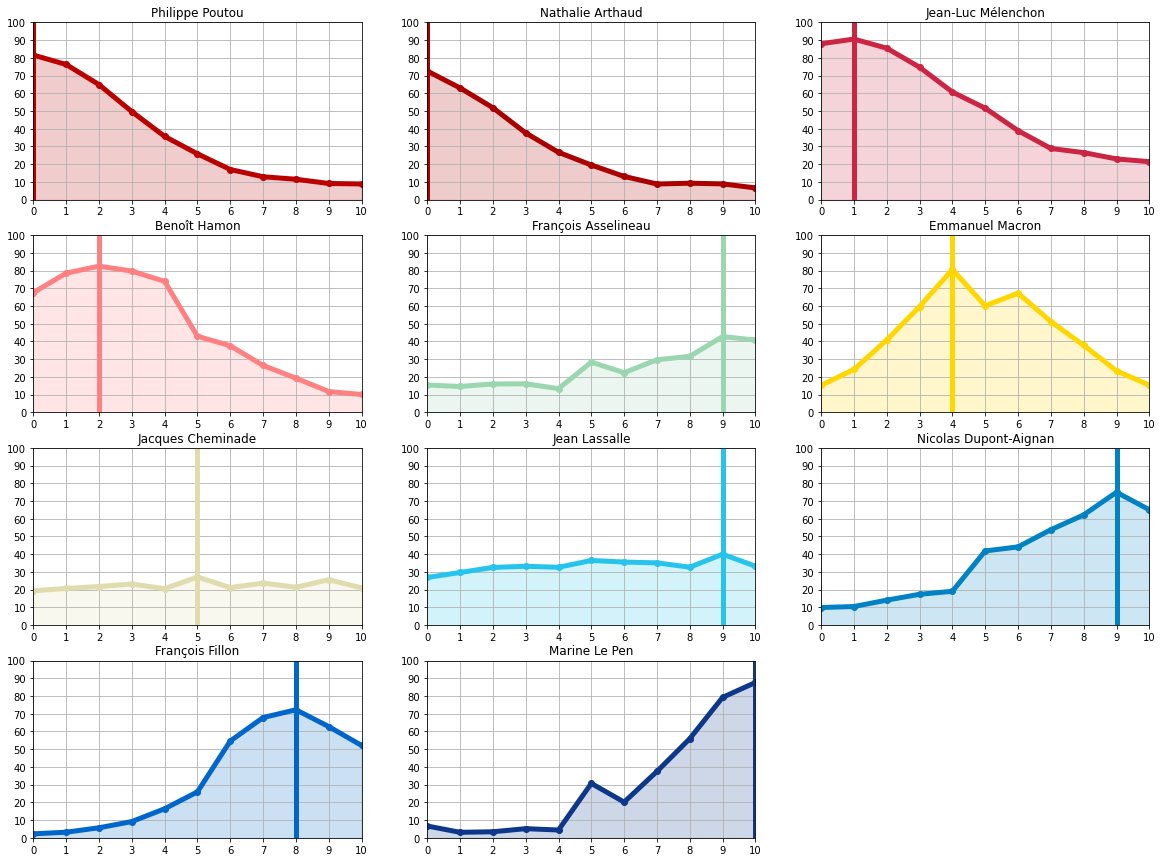

In [10]:
notes = pd.read_csv('../Voter Autrement - 2017 - Online/votes/notes.csv')
notes = notes.to_numpy()

dict_candidates = {}
for c in candidates:
    dict_candidates[c] = {"opinions":np.zeros(11), "count":np.zeros(11)}

for x in notes:
    if x[0] not in dict_positions:
        continue
    pos = int(dict_positions[x[0]])
    for i, c in enumerate(candidates):
        if not(pd.isna(x[i+1])):
            dict_candidates[candidates_app[i]]["opinions"][pos] += w[x[0]]*x[i+1]
            dict_candidates[candidates_app[i]]["count"][pos] += w[x[0]]


fig = plt.figure(figsize=(20,15))

for i, key in enumerate(cand_list):
    # subfigure 
    ax = fig.add_subplot(4, 3, cand_list.index(key)+1)
    ax.set_title(key)
    ax.set_ylim([0,100])
    ax.set_xlim([0,10])
    ax.set_xticks(range(11))
    ax.set_xticklabels(range(11))
    ax.set_yticks(range(0,101,10))
    ax.set_yticklabels(range(0,101,10))
    ax.grid(True)
    ax.plot(range(11), dict_candidates[key]["opinions"]/dict_candidates[key]["count"], "o-", color=candidates[key], linewidth=5)
    # area between 
    ax.fill_between(range(11), dict_candidates[key]["opinions"]/dict_candidates[key]["count"], color=candidates[key], alpha=0.2)
    # dark line for best position 
    best_score = np.argmax(dict_candidates[key]["opinions"]/dict_candidates[key]["count"])
    ax.plot([best_score, best_score], [0, 100], color=candidates[key], linewidth=5)


On repére seulement une anomalie autour de la position "5", surement car c'est la position "par défaut" que les participants mettent sans réflechir.
Fait intéressant : Alors que ses soutient sont plutot à gauche, ce sont les gens de droite qui ont une meilleure opinion de Asselineau

On peut s'amuser à comparer quasiment tous les paramètres aux positions sur l'axe:
- Le vote au second tour
- Les scores moyens donnés
- L'âge, le genre, la catégorie socio-professionnelle, le niveau d'étude
- Les avis sur le vote (un droit, une chance, un devoir ?)

Je ne vais faire que le dernier ici, je laisse au lecteur l'exercice de faire les autres

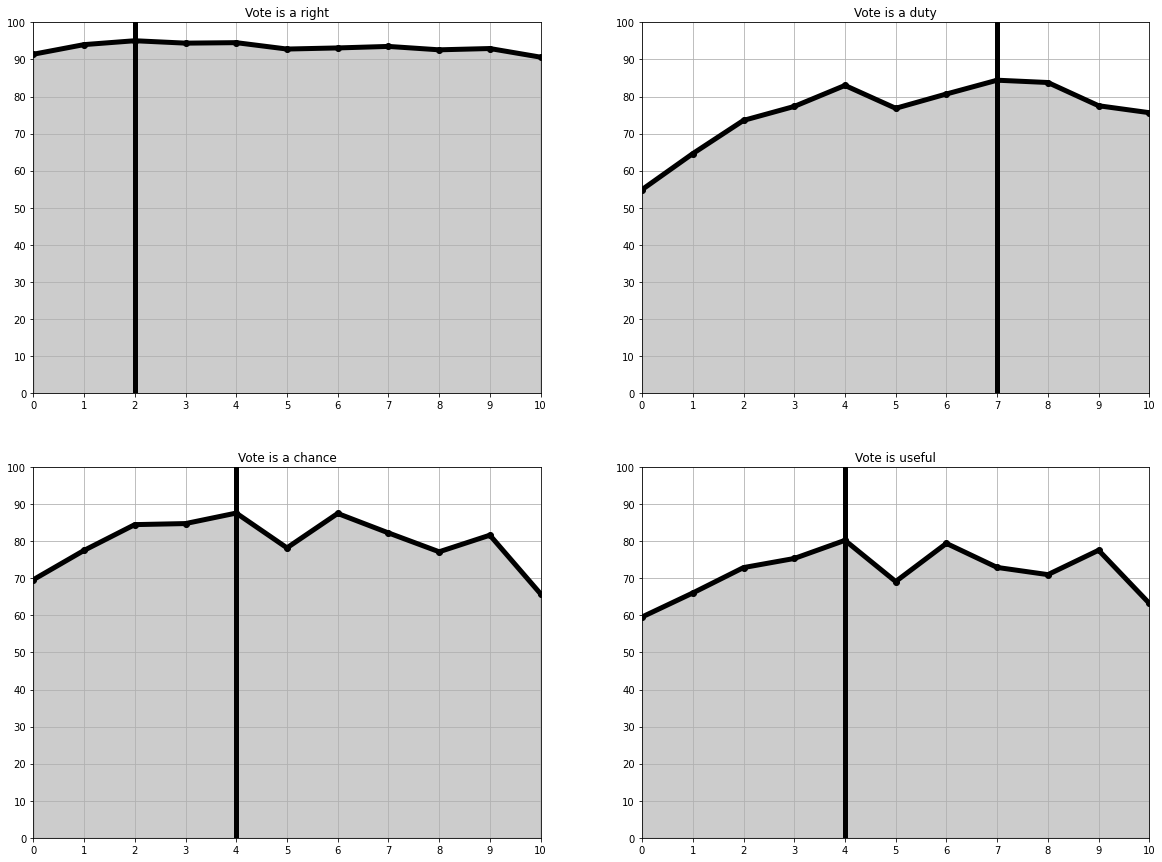

In [12]:

positions = voters_online[['id','position','official_vote', "vote_is_a_right","vote_is_a_duty","vote_is_a_chance","vote_is_useful"]].to_numpy()


dict_positions = [np.zeros(11) for i in range(4)]
dict_positions_count = [np.zeros(11) for i in range(4)]

for x in positions:
    if not pd.isna(x[1]):
        pos = int(x[1])
        for i in range(4):
            dict_positions_count[i][pos] += w[x[0]]
            if x[i+3] == 1:
                dict_positions[i][pos] += w[x[0]]

fig = plt.figure(figsize=(20,15))

for i, key in enumerate(["Vote is a right","Vote is a duty","Vote is a chance","Vote is useful"]):
    # subfigure 
    ax = fig.add_subplot(2, 2, i+1)
    ax.set_title(key)
    ax.set_ylim([0,100])
    ax.set_xlim([0,10])
    ax.set_xticks(range(11))
    ax.set_xticklabels(range(11))
    ax.set_yticks(range(0,101,10))
    ax.set_yticklabels(range(0,101,10))
    ax.grid(True)
    ax.plot(range(11), dict_positions[i]*100/dict_positions_count[i], "o-", color="black", linewidth=5)
    # area between 
    ax.fill_between(range(11), dict_positions[i]*100/dict_positions_count[i], color="black", alpha=0.2)
    # dark line for best position 
    best_score = np.argmax(dict_positions[i]*100/dict_positions_count[i])
    ax.plot([best_score, best_score], [0, 100], color="black", linewidth=5)

## 1.B. 2017 - Strasbourg 

Obtient t-on les mêmes résultats à Strasbourg ?

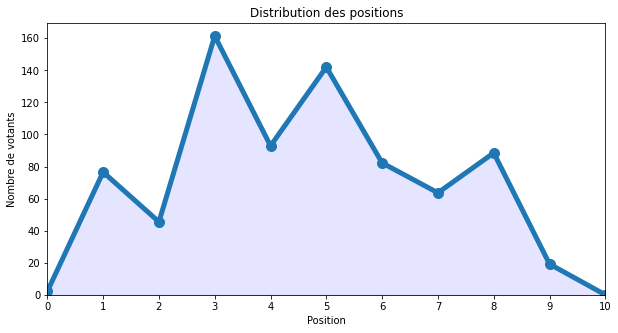

In [13]:
voters_online = pd.read_csv('../Voter Autrement - 2017 - In Situ Strasbourg/voters.csv')
weights = pd.read_csv('../Voter Autrement - 2017 - In Situ Strasbourg/weights.csv', index_col=0)
positions = voters_online[['id','position']].to_numpy()
w = weights["approval"].to_dict()
distrib = np.zeros(11)
for x in positions:
    if not pd.isna(x[1]):
        distrib[int(x[1])] += w[x[0]]


fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_title('Distribution des positions')
ax.set_xlabel('Position')
ax.set_ylabel('Nombre de votants')
ax.set_xticks(range(11))
# ax.set_xticklabels(['Très à gauche', 'Plutôt à gauche', 'Légèrement à gauche', 'Centre', 'Légèrement à droite', 'Plutôt à droite', 'Très à droite', 'Extrême gauche', 'Extrême droite', 'Autre', 'Ne se prononce pas'])
plt.plot(range(11), distrib, 'o-', linewidth=5, markersize=10)
plt.fill_between(range(11), distrib, color='blue', alpha=0.1)
plt.xlim(0,10)
plt.ylim(0)
plt.show()

Cette fois ci, très peu d'extremiste : 0 personne à 0 et 0 personnes à 10

821


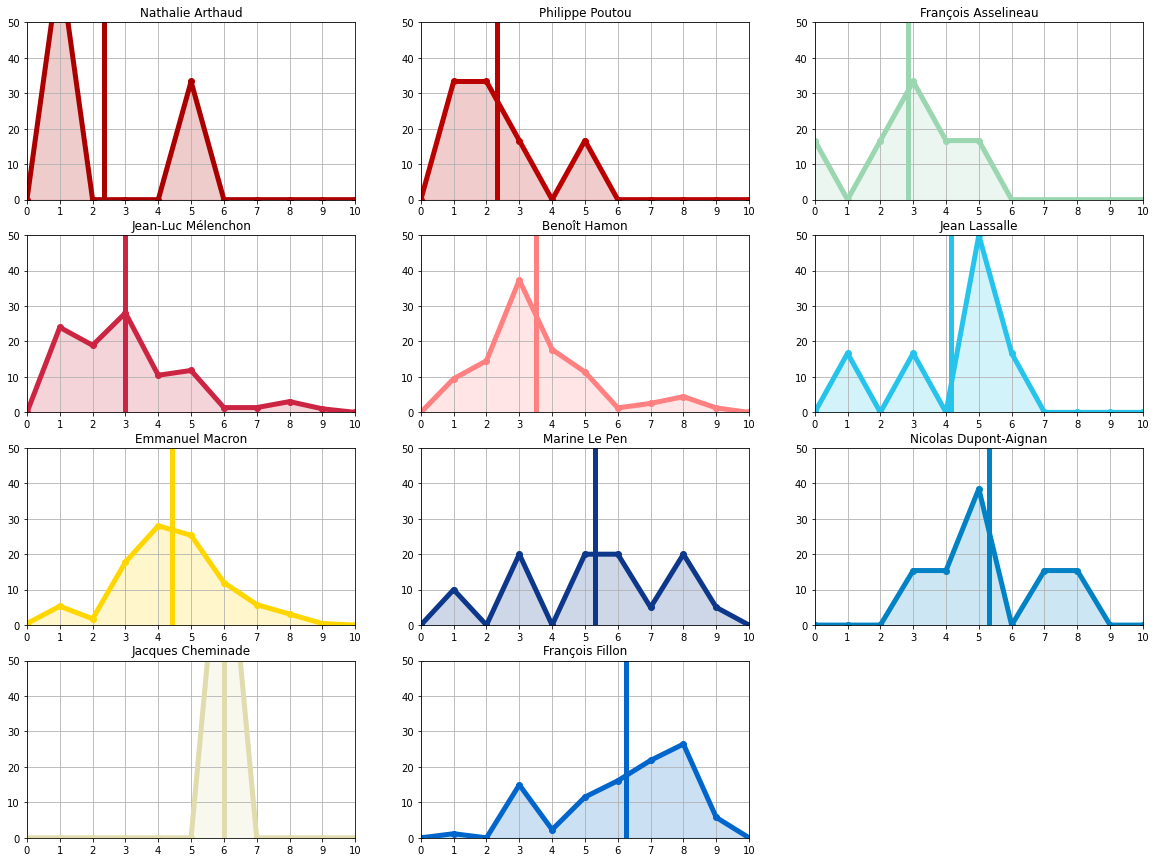

In [14]:
dict_candidates = {}
for c in candidates:
    dict_candidates[c] = np.zeros(11)
positions = voters_online[['id','position','official_vote']].to_numpy()
c = 0
for x in positions:
    if not pd.isna(x[1]):
        if x[2] in candidates:
            dict_candidates[x[2]][int(x[1])] += 1
            c += 1

print(c)


fig = plt.figure(figsize=(20,15))
mean = [np.sum([dict_candidates[c][i]*i for i in range(11)])/np.sum([dict_candidates[c][i] for i in range(11)]) for c in dict_candidates]
order = np.argsort(mean)
cand_list = [list(dict_candidates.keys())[i] for i in order]

for i, key in enumerate(cand_list):
    # subfigure 
    ax = fig.add_subplot(4, 3, cand_list.index(key)+1)
    ax.set_title(key)
    ax.set_ylim([0,50])
    ax.set_xlim([0,10])
    ax.set_xticks(range(11))
    ax.set_xticklabels(range(11))
    ax.set_yticks(range(0,51,10))
    ax.set_yticklabels(range(0,51,10))
    ax.grid(True)
    ax.plot(range(11), dict_candidates[key]*100/sum(dict_candidates[key]), "o-", color=candidates[key], linewidth=5)
    # area between 
    ax.fill_between(range(11), dict_candidates[key]*100/sum(dict_candidates[key]), color=candidates[key], alpha=0.2)
    # dark line for mean
    ax.plot([mean[order[i]], mean[order[i]]], [0, 50], color=candidates[key], linewidth=5)
plt.show()

Bon... C'est pas terrible... il faut dire qu'avec seulement 800 participants, et 11 candidats, certains candidats se retrouvent avec très peu de participants. En utilisant les données d'approval, on y vera déjà un peu plus clair, puisque chaque participant peut approuver plusieurs candidats

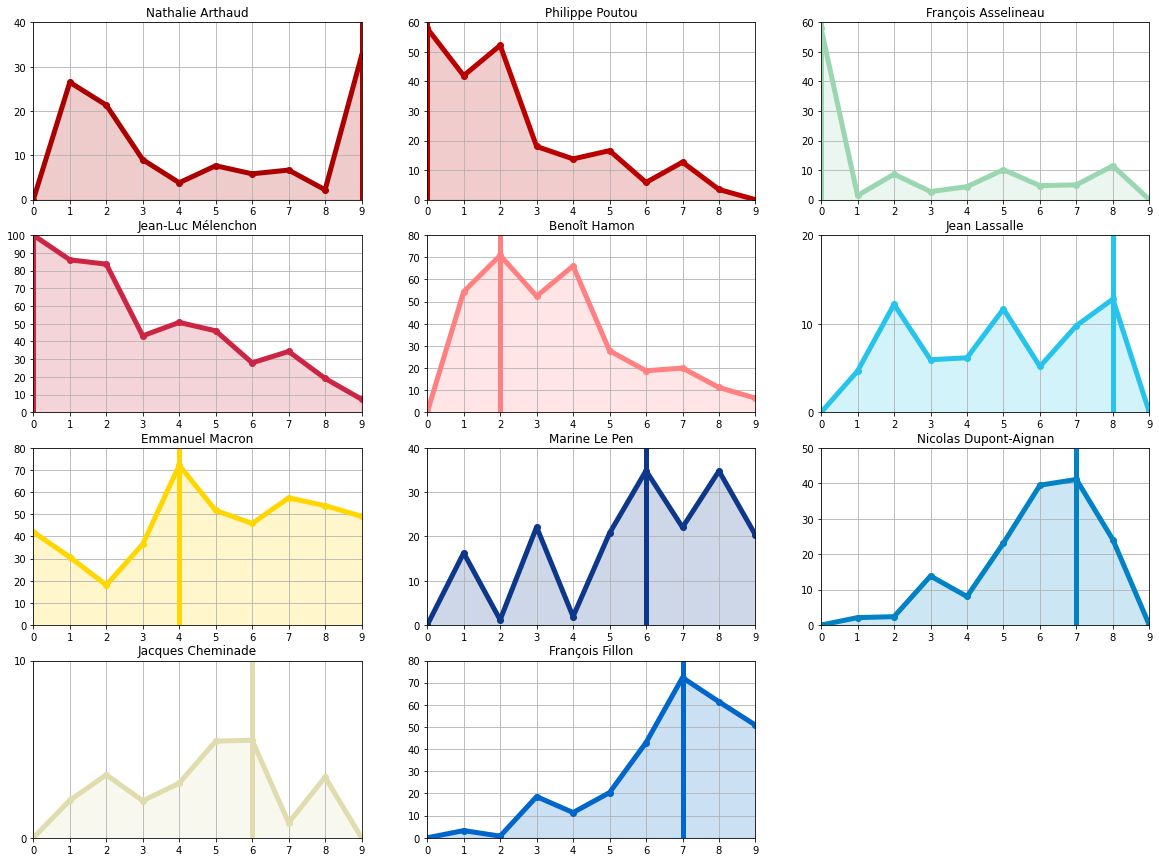

In [15]:
approval  = pd.read_csv('../Voter Autrement - 2017 - In Situ Strasbourg/votes/approval.csv')
candidates_app = list(approval.columns[1:])
approval = approval.to_numpy()
positions = voters_online[['id','position']].to_numpy()
dict_positions = {}
for x in positions:
    if not pd.isna(x[1]):
        dict_positions[x[0]] = int(x[1])

dict_candidates = {}
for c in candidates:
    dict_candidates[c] = np.zeros(10)
dict_candidates["total"] = np.zeros(10)

for x in approval:
    if x[0] not in dict_positions:
        continue
    pos = int(dict_positions[x[0]])
    for i, c in enumerate(candidates):
        if x[i+1] == 1:
            dict_candidates[candidates_app[i]][pos] += w[x[0]]
    dict_candidates["total"][pos] += w[x[0]]

fig = plt.figure(figsize=(20,15))

for i, key in enumerate(cand_list):
    # subfigure 
    ax = fig.add_subplot(4, 3, cand_list.index(key)+1)
    max_pct = min(100, int(max(dict_candidates[key]*100/dict_candidates["total"])/10)*10+10)
    ax.set_title(key)
    ax.set_ylim([0,max_pct])
    ax.set_xlim([0,9])
    ax.set_xticks(range(10))
    ax.set_xticklabels(range(10))
    ax.set_yticks(range(0,max_pct+1,10))
    ax.set_yticklabels(range(0,max_pct+1,10))
    ax.grid(True)
    ax.plot(range(10), dict_candidates[key]*100/dict_candidates["total"], "o-", color=candidates[key], linewidth=5)
    # area between 
    ax.fill_between(range(10), dict_candidates[key]*100/dict_candidates["total"], color=candidates[key], alpha=0.2)
    # dark line for best position 
    best_score = np.argmax(dict_candidates[key]*100/dict_candidates["total"])
    ax.plot([best_score, best_score], [0, max_pct], color=candidates[key], linewidth=5)

Bon... Ce n'est pas beaucoup mieux malheureusement...

# 2. Deviner l'axe, à partir des approbations

In [2]:
dataset = "Voter Autrement - 2017 - Online"
approval  = pd.read_csv('../%s/votes/approval.csv'%dataset)
weights = pd.read_csv('../%s/weights.csv'%dataset, index_col=0)
candidates = pd.read_csv('../%s/candidates.csv'%dataset, index_col=0).to_numpy()
id_app = approval.to_numpy()[:,0]
approval = approval.to_numpy()[:,1:]
cands_name = [candidates[i][0] for i in range(len(candidates))]
w = []
for i in range(len(id_app)):
    if id_app[i] in weights.index:
        w.append(weights["approval"][id_app[i]])
    else:
        w.append(0)

w = np.array(w)
print(w.shape)


(20076,)


In [3]:
print(approval.shape)
print(np.sum([w[i] for i in range(len(approval)) if np.sum(approval[i]) > 0 and np.sum(approval[i]) < 11]))
print(np.sum([w[i] for i in range(len(approval)) if np.sum(approval[i]) > 1 and np.sum(approval[i]) < 11]))


(20076, 11)
16628.055869762662
13527.617327350075


In [4]:
6129.033242233285/9674.35822979081

0.6335338320799202

In [5]:
print("VD")
axis_vd = ax.get_axis(approval, ax.voter_deletion, w)
print("BC")
axis_bc = ax.get_axis(approval, ax.ballot_completion, w)
print("VD-circle")
axis_vdc = ax.get_axis(approval, ax.circular_voter_deletion, w, circular=True)
print("BC-circle")
axis_bcc = ax.get_axis(approval, ax.circular_ballot_completion, w, circular=True)

VD
BC
VD-circle
BC


In [11]:
axis_ms = ax.get_axis(approval, ax.minimal_swaps, w)
axis_ft = ax.get_axis(approval, ax.forbidden_triples, w)

In [12]:
print ("Voter Deletion")
ax.print_order(axis_vd[0][0], cands_name)
print(axis_vd[0][1],len(axis_vd))
print ("Ballot Completion")
ax.print_order(axis_bc[0][0], cands_name)
print(axis_bc[0][1],len(axis_bc))
print ("Minimal Swaps")
ax.print_order(axis_ms[0][0], cands_name)
print(axis_ms[0][1],len(axis_ms))
print ("Forbidden Triples")
ax.print_order(axis_ft[0][0], cands_name)
print(axis_ft[0][1],len(axis_ft))
print ("Circular Voter Deletion")
ax.print_order(axis_vdc[0][0], cands_name)
print(axis_vdc[0][1],len(axis_vdc))
print ("Circular Ballot Completion")
ax.print_order(axis_bcc[0][0], cands_name)
print(axis_bcc[0][1],len(axis_bcc))


Voter Deletion
Jacques Cheminade < François Asselineau < Marine Le Pen < Nicolas Dupont-Aignan < François Fillon < Emmanuel Macron < Benoît Hamon < Jean-Luc Mélenchon < Philippe Poutou < Nathalie Arthaud < Jean Lassalle
5685.0506224655655 1
Ballot Completion
Jacques Cheminade < François Asselineau < Jean Lassalle < Marine Le Pen < Nicolas Dupont-Aignan < François Fillon < Emmanuel Macron < Benoît Hamon < Jean-Luc Mélenchon < Philippe Poutou < Nathalie Arthaud
15503.139006783107 1
Minimal Swaps
Jacques Cheminade < François Asselineau < Jean Lassalle < Marine Le Pen < Nicolas Dupont-Aignan < François Fillon < Emmanuel Macron < Benoît Hamon < Jean-Luc Mélenchon < Philippe Poutou < Nathalie Arthaud
17925.44880932073 1
Forbidden Triples
Jacques Cheminade < François Asselineau < Marine Le Pen < Nicolas Dupont-Aignan < François Fillon < Jean Lassalle < Emmanuel Macron < Jean-Luc Mélenchon < Benoît Hamon < Philippe Poutou < Nathalie Arthaud
43471.30898854542 1
Circular Voter Deletion
Jean-Luc 

In [10]:
12338.526280840402/13527.617327350075

0.912099003266039

In [18]:
notes = pd.read_csv('../Voter Autrement - 2017 - Online/votes/notes.csv')
notes = notes.to_numpy()

order = [cands_name[x] for x in axis_bc[0][0]][::-1]
dict_opinions = np.zeros((11,11))
dict_count = np.zeros((11,11))

for x in notes:
    if x[0] not in dict_positions:
        continue
    pos = int(dict_positions[x[0]])
    for i, c in enumerate(candidates):
        if not(pd.isna(x[i+1])):
            pos_c = order.index(candidates_app[i])
            dict_opinions[pos][pos_c] += w[int(x[0])]*x[i+1]
            dict_count[pos][pos_c]  += w[int(x[0])]


fig = plt.figure(figsize=(20,7))
def only_upper(s):
    upper_chars = ""
    for char in s:
        if char.isupper():
            upper_chars += char
    return upper_chars


for i in range(5,11):
    # subfigure 
    ax = fig.add_subplot(2, 3, i-5+1)
    ax.set_title("Position %d on left-right axis"%i)
    ax.set_ylim([0,100])
    ax.set_xlim([0,10])
    ax.set_xticks(range(11))
    ax.set_xticklabels([only_upper(x) for x in order], rotation=0)
    ax.set_yticks(range(0,101,10))
    ax.set_yticklabels(range(0,101,10))
    ax.grid(True)
    ax.plot(range(11), dict_opinions[i]/dict_count[i], "o-", color="k", linewidth=5)
    # area between 
    ax.fill_between(range(11), dict_opinions[i]/dict_count[i],  color="k", alpha=0.2)

plt.savefig("opinions_2.png")
tikzplotlib.save("opinions_2.tex")
plt.show()


NameError: name 'dict_positions' is not defined

Les deux règles nous donnent des axes très similaires. Il semblerait que "ballot completion" pousse encore plus les petits partis vers les extrêmes, avec Dupont-Aignan qui échange sa place avec Marine Le Pen, et Mélenchon qui échange avec Hamon. De plus, les petits candidats sont tous "extrêmes", mais est-ce vraiment leur place ?

In [ ]:
scores = ax.compute_scores(approval, w)
axis_vd_th = ax.get_axis(approval, ax.create_voter_deletion_alpha(scores), w)
ax.print_order(axis_vd_th[0][0], cands_name)

Marine Le Pen < Nicolas Dupont-Aignan < Jacques Cheminade < François Asselineau < François Fillon < Emmanuel Macron < Jean Lassalle < Benoît Hamon < Nathalie Arthaud < Philippe Poutou < Jean-Luc Mélenchon


In [ ]:
scores = ax.compute_scores(approval, w)
axis_bc_th = ax.get_axis(approval, ax.create_ballot_completion_alpha(scores), w)
ax.print_order(axis_bc_th[0][0], cands_name)

Nathalie Arthaud < Benoît Hamon < Philippe Poutou < Jean-Luc Mélenchon < Jean Lassalle < Emmanuel Macron < Jacques Cheminade < François Asselineau < Nicolas Dupont-Aignan < Marine Le Pen < François Fillon


Est-ce plus convainquant ?

In [ ]:
scores = ax.compute_scores(approval, w)/approval.shape[0]
axis_bc_pond = ax.get_axis(approval, ax.create_ballot_completion_pond(scores), w)
ax.print_order(axis_bc_pond[0][0], cands_name)

Jacques Cheminade < François Asselineau < Marine Le Pen < Nicolas Dupont-Aignan < François Fillon < Jean Lassalle < Emmanuel Macron < Jean-Luc Mélenchon < Benoît Hamon < Philippe Poutou < Nathalie Arthaud


## 2.2. Machine Learning

In [3]:
from sklearn.manifold import TSNE, Isomap, MDS, SpectralEmbedding

In [33]:
res_tsne = TSNE(1, perplexity=5,n_iter=10000).fit_transform(approval.T)[:,0]
ax.print_order(np.argsort(res_tsne), cands_name)
# Change a chaque fois

Nicolas Dupont-Aignan < Emmanuel Macron < Jean Lassalle < François Asselineau < Jacques Cheminade < Marine Le Pen < Nathalie Arthaud < Philippe Poutou < Jean-Luc Mélenchon < Benoît Hamon < François Fillon


In [36]:
res_tsne = Isomap(n_components=1, n_neighbors=1).fit_transform(approval.T)[:,0]
ax.print_order(np.argsort(res_tsne), cands_name)

Philippe Poutou < Nathalie Arthaud < Nicolas Dupont-Aignan < Jean Lassalle < François Asselineau < Jacques Cheminade < Marine Le Pen < Benoît Hamon < Jean-Luc Mélenchon < François Fillon < Emmanuel Macron


In [36]:
res_tsne = MDS(n_components=1).fit_transform(approval.T)[:,0]
ax.print_order(np.argsort(res_tsne), cands_name)

Emmanuel Macron < François Asselineau < Nathalie Arthaud < Nicolas Dupont-Aignan < Marine Le Pen < Jacques Cheminade < Jean Lassalle < François Fillon < Jean-Luc Mélenchon < Benoît Hamon < Philippe Poutou


In [35]:
from sklearn.decomposition import PCA
print(approval.T.shape)
weighted_app= approval.T# np.array([approval.T[i]*w[i] for i in range(len(approval.T))])
pca = PCA(n_components=10)
pca.fit(approval.T)
res = pca.transform(weighted_app)
print(pca.explained_variance_)
print(res[:,0])
ax.print_order(np.argsort(res[:,0]), cands_name)


(11, 20076)
[1695.93328416  694.76075136  326.66663718  286.89768009  175.67391057
  171.13856437  131.2794957   103.55423729   81.21089109   67.41182092]
[ -1.17808916 -29.79287821 -27.8275201  -31.18014868 -33.06828948
  71.99580124 -23.43229285 -32.6855903    3.61757716  74.74192135
  28.80950902]
François Fillon < Marine Le Pen < Nicolas Dupont-Aignan < François Asselineau < Jacques Cheminade < Jean Lassalle < Nathalie Arthaud < Emmanuel Macron < Philippe Poutou < Benoît Hamon < Jean-Luc Mélenchon


In [54]:
pos = TSNE(2, perplexity=5,n_iter=2000).fit_transform(approval)
approval_id  = pd.read_csv('../Voter Autrement - 2017 - In Situ Strasbourg/votes/approval.csv')["id"].to_numpy()
voters = pd.read_csv('../Voter Autrement - 2017 - In Situ Strasbourg/voters.csv')
real_votes = {}
j = 0
for _, row in voters.iterrows():
    if row["id"] in approval_id:
        vote = row["official_vote"]
        if vote not in real_votes:
            real_votes[vote] = []
        real_votes[vote].append(j)
        j += 1


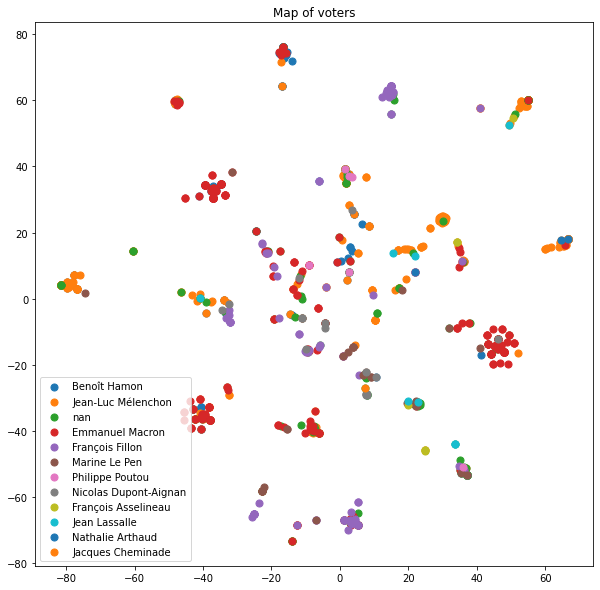

In [56]:

plt.figure(figsize=(10,10))
for i in real_votes:
    pos_i = np.array(pos)[real_votes[i]]
    plt.scatter([p[0] for p in pos_i], [p[1] for p in pos_i],label=i, s=50)
    
plt.legend()
plt.title("Map of voters")
plt.show()

[0.40188928 0.26675643 0.17130783 0.1559896  0.12470756 0.09490892
 0.06851592 0.06613152 0.05897526 0.04659025]


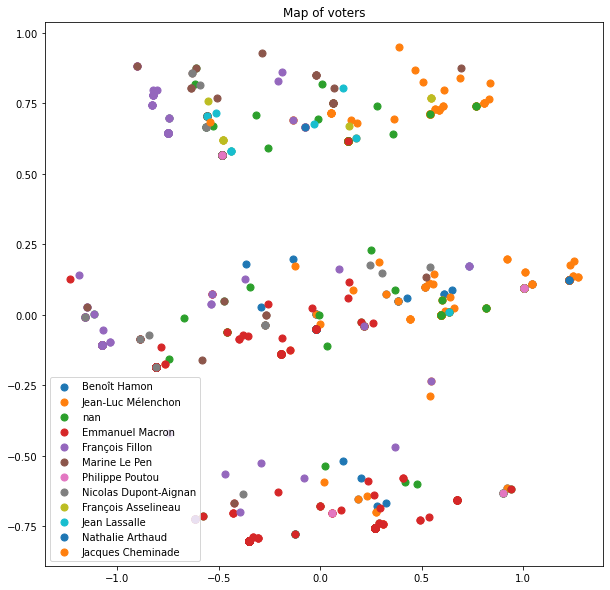

In [57]:
pca = PCA(n_components=10)
pca.fit(approval)
res = pca.transform(approval)
print(pca.explained_variance_)
pos = res[:,:2]
plt.figure(figsize=(10,10))
for i in real_votes:
    pos_i = np.array(pos)[real_votes[i]]
    plt.scatter([p[0] for p in pos_i], [p[1] for p in pos_i],label=i, s=50)
    
plt.legend()
plt.title("Map of voters")
plt.show()

# 3. Simulations

## 3.1. The model 

This model works as a metric model, a 1-D metric model. Every voter and every candidate is associated to a position on this metric space. Of course, if every voter has an approval radius and only approves candidates close to them, then the profile will be continuous, and not very interesting for us, as all rules will return the correct axis. This is why every voter has a probability to approve a candidate that depends on the distance between

It has two parameters :

* $\alpha > 0$ controls how restrictive voters are in their approval ballots: the higher $\alpha$, the higher the probability to approve a candidate.
* $\beta \in [0,1]$ controls the influence differences between candidates. If $\beta = 0$, all candidates have the same probability to be approved, but if $\beta = 1$, this probability is multiplied by a parameter that depends on the candidates only, which we will call the *influence* of the voter, and denote $S(c) \in [0,1]$ (drawn uniformly at random).

If we denote $d(v,c)$ the distance function between candidates and voters, the probability for a voter $v \in V$ to approve a candidate $c \in C$ is equal to 

$$
e^{-\alpha d(v,c)}(S(c)\beta + 1 - \beta)
$$

If $\alpha = 1$ and $\beta = 0$, we have the very simple equation in which the probability for $v$ to approve $c$ is equal to $e^{-d(v,c)}$

Let's first quickly study the impact of the parameters on this model. First, it is clear that as $\alpha$ increases, the number of approved candidates (in average) also increases.

In [45]:
alpha_tested = [0.1,0.5,1,2,5,10,50][::-1]
number_approval = np.zeros((11,len(alpha_tested)))
n_trys = 100
for i, alpha in tqdm(enumerate(alpha_tested)):
    for _ in range(n_trys):
        app, _, _ = ax.generate_profile(10, 1000, alpha, beta=0)
        appsum = app.sum(1)
        count = [len(np.where(appsum==i)[0]) for i in range(11)]
        number_approval[:,i] += count 

7it [00:15,  2.22s/it]


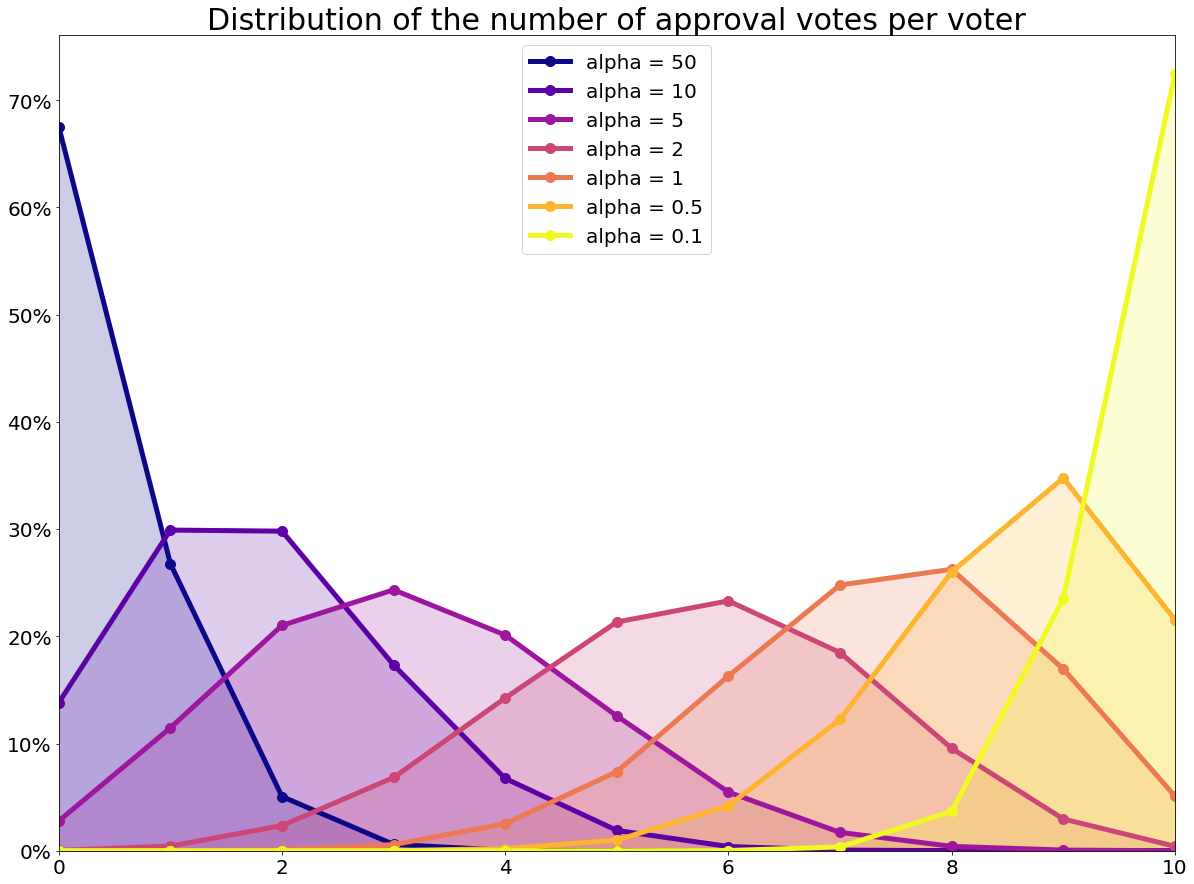

In [46]:
fig = plt.figure(figsize=(20,15))

#I want a gradient of colors 
colors = plt.cm.plasma(np.linspace(0,1,len(alpha_tested)))

for i, alpha in enumerate(alpha_tested):
    plt.plot(range(11), 100*number_approval[:,i]/np.sum(number_approval[:,i]), "o-", color=colors[i], label="alpha = "+str(alpha), linewidth=5, markersize=10)
    plt.fill_between(range(11), 100*number_approval[:,i]/np.sum(number_approval[:,i]), color=colors[i],  alpha=0.2)

plt.title("Distribution of the number of approval votes per voter", fontsize=30)
plt.xlim(0,10)
plt.xticks(fontsize=20)
plt.yticks(range(0,71,10), [str(i)+"%" for i in range(0,71,10)], fontsize=20)
plt.ylim(0)

plt.legend(fontsize=20)
plt.savefig("axis/figs/number_approval.png")
tikzplotlib.save("axis/figs/number_approval.tex")
plt.show()

Dans les données réelles, selon les données, on retrouve souvent une gaussienne (comme présentée ici), centré entre 1 (lorsque les votants sont très "fanatiques") et 5 (pour des données moins politique, par exemple un parfum de glace). C'est pourquoi, si $\beta = 0$, alors on devrait probablement utiliser $\alpha \ge 2$. Qu'en est-il si on change $\beta$. Si $\beta = 0.5$, alors on obtient le graphique suivant.

7it [00:15,  2.26s/it]


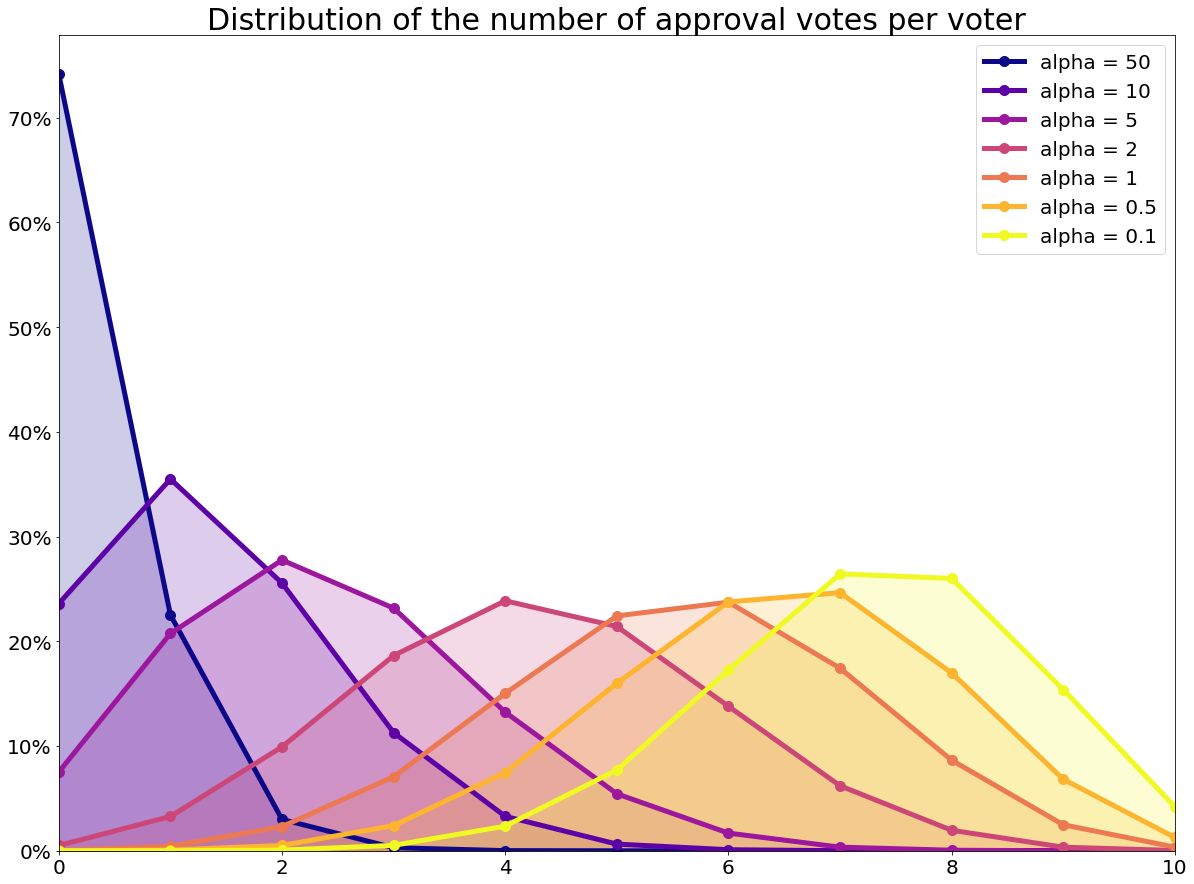

In [38]:
alpha_tested = [0.1,0.5,1,2,5,10,50][::-1]
number_approval = np.zeros((11,len(alpha_tested)))
n_trys = 100
for i, alpha in tqdm(enumerate(alpha_tested)):
    for _ in range(n_trys):
        app, _, _ = ax.generate_profile(10, 1000, alpha, beta=0.5)
        appsum = app.sum(1)
        count = [len(np.where(appsum==i)[0]) for i in range(11)]
        number_approval[:,i] += count 

fig = plt.figure(figsize=(20,15))

for i, alpha in enumerate(alpha_tested):
    plt.plot(range(11), 100*number_approval[:,i]/np.sum(number_approval[:,i]), "o-", color=colors[i], label="alpha = "+str(alpha), linewidth=5, markersize=10)
    plt.fill_between(range(11), 100*number_approval[:,i]/np.sum(number_approval[:,i]), color=colors[i],  alpha=0.2)

plt.title("Distribution of the number of approval votes per voter", fontsize=30)
plt.xlim(0,10)
plt.xticks(fontsize=20)
plt.yticks(range(0,71,10), [str(i)+"%" for i in range(0,71,10)], fontsize=20)
plt.ylim(0)
plt.legend(fontsize=20)
plt.savefig("axis/figs/number_approval_beta_0_5.png")
tikzplotlib.save("axis/figs/number_approval_beta_0_5.tex")
plt.show() 

En fait, la probabilité dépend ici quasiment autant de la distance entre $v$ et $c$ que de l'influence de $c$. Le constat est encore pire si $\beta = 1$, ou l'ordre des courbes n'est même plus respectés.

7it [00:16,  2.33s/it]


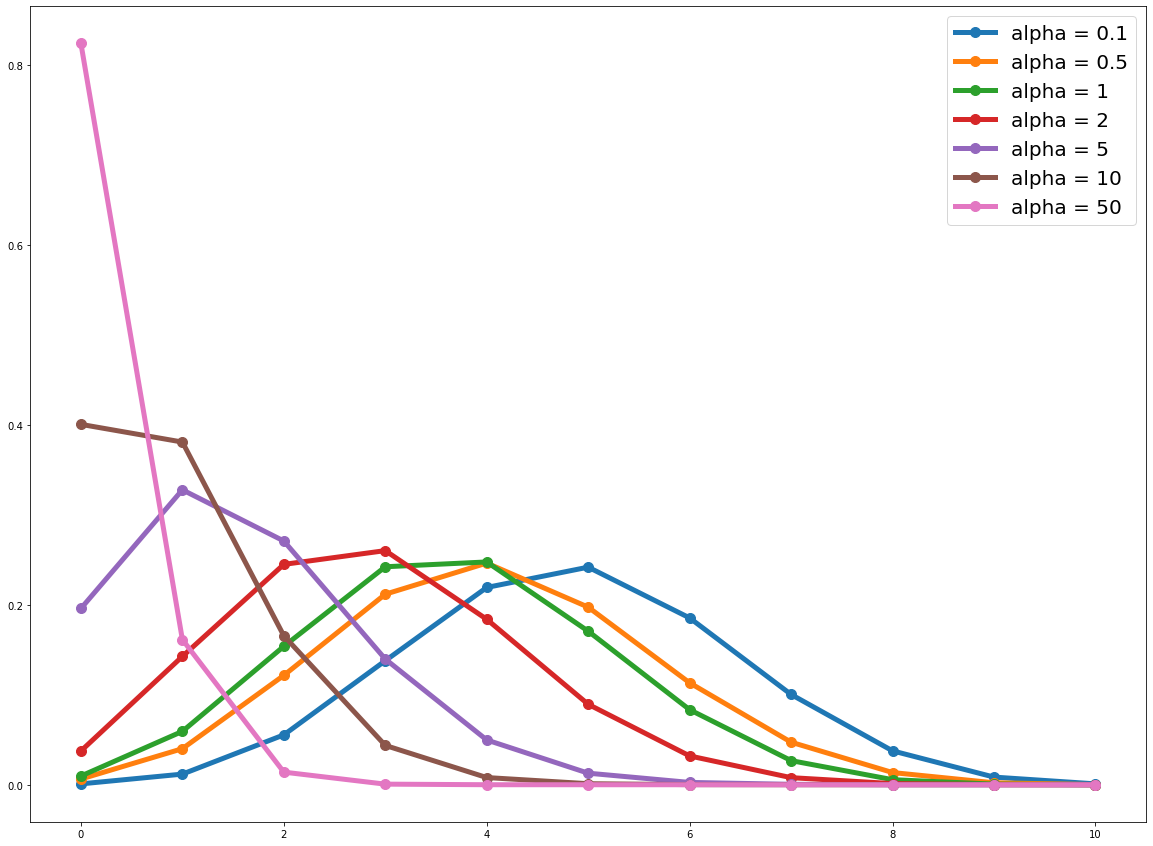

In [ ]:
alpha_tested = [0.1,0.5,1,2,5,10,50]
number_approval = np.zeros((11,len(alpha_tested)))
n_trys = 100
for i, alpha in tqdm(enumerate(alpha_tested)):
    for _ in range(n_trys):
        app, _, _ = ax.generate_profile(10, 1000, alpha, beta=1)
        appsum = app.sum(1)
        count = [len(np.where(appsum==i)[0]) for i in range(11)]
        number_approval[:,i] += count 

fig = plt.figure(figsize=(20,15))

for i, alpha in enumerate(alpha_tested):
    plt.plot(range(11), number_approval[:,i]/np.sum(number_approval[:,i]), "o-", label="alpha = "+str(alpha), linewidth=5, markersize=10)


plt.legend(fontsize=20)
plt.show() 

On peut aussi faire varier $\alpha$ à $\beta$ fixé

6it [00:13,  2.28s/it]


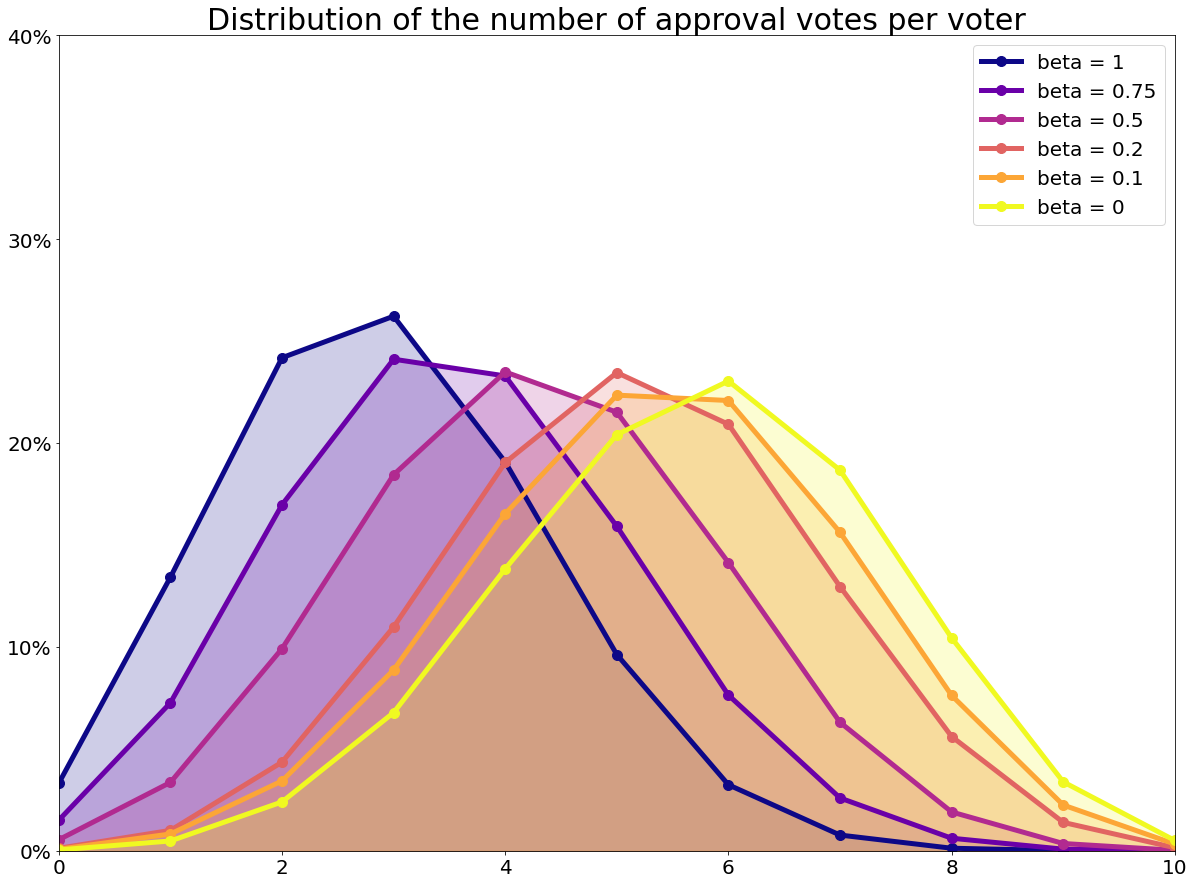

In [51]:

beta_tested = [0,0.1,0.2,0.5,0.75,1][::-1]
number_approval = np.zeros((11,len(alpha_tested)))
n_trys = 100
for i, beta in tqdm(enumerate(beta_tested)):
    for _ in range(n_trys):
        app, _, _ = ax.generate_profile(10, 1000, alpha=2, beta=beta)
        appsum = app.sum(1)
        count = [len(np.where(appsum==i)[0]) for i in range(11)]
        number_approval[:,i] += count 

fig = plt.figure(figsize=(20,15))

colors = plt.cm.plasma(np.linspace(0,1,len(beta_tested)))
for i, beta in enumerate(beta_tested):
    plt.plot(range(11), 100*number_approval[:,i]/np.sum(number_approval[:,i]), "o-", color=colors[i], label="beta = "+str(beta), linewidth=5, markersize=10)
    plt.fill_between(range(11), 100*number_approval[:,i]/np.sum(number_approval[:,i]), color=colors[i],  alpha=0.2)

plt.title("Distribution of the number of approval votes per voter", fontsize=30)
plt.xlim(0,10)
plt.xticks(fontsize=20)
plt.yticks(range(0,41,10), [str(i)+"%" for i in range(0,41,10)], fontsize=20)
plt.ylim(0)
plt.legend(fontsize=20)
plt.savefig("axis/figs/number_approval_alpha_2.png")
tikzplotlib.save("axis/figs/number_approval_alpha_2.tex")
plt.show() 

## 3.2. Running time

Utilisons $\alpha = 5$ et $\beta = 0.5$. Comment évolue le running time avec les méthodes bruteforce et linear ?

Fixons d'abord le nombre de candidats ($m = 6$) et faisons varier le nombre de votants de $10$ à $100 000$

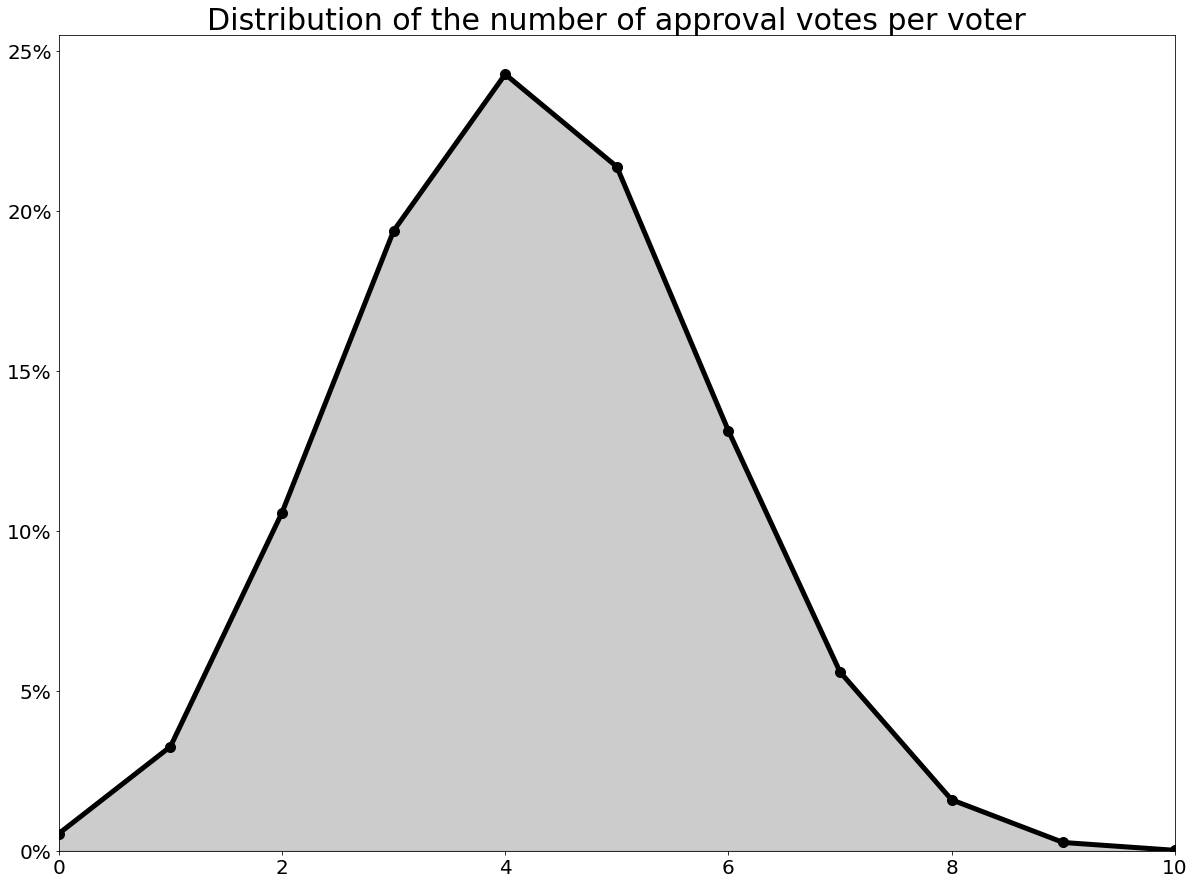

In [40]:

n_trys = 100
number_approval = np.zeros((11,len(alpha_tested)))
for _ in range(n_trys):
    app, _, _ = ax.generate_profile(10, 1000, alpha=2, beta=0.5)
    appsum = app.sum(1)
    count = [len(np.where(appsum==i)[0]) for i in range(11)]
    number_approval[:,i] += count 

fig = plt.figure(figsize=(20,15))

plt.plot(range(11), 100*number_approval[:,i]/np.sum(number_approval[:,i]), "o-", color="k",  linewidth=5, markersize=10)
plt.fill_between(range(11), 100*number_approval[:,i]/np.sum(number_approval[:,i]), alpha=0.2, color="k")

plt.title("Distribution of the number of approval votes per voter", fontsize=30)
plt.xlim(0,10)
plt.ylim(0)
plt.yticks(range(0,26,5), [str(i)+"%" for i in range(0,26,5)], fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("axis/figs/number_approval_simu_time.png")
tikzplotlib.save("axis/figs/number_approval_simu_time.tex")
plt.show() 

In [41]:
n_voters_tested = [10**i for i in range(1,6)]
print(n_voters_tested)
m_candidates = 6
n_trys = 100
time_tab = np.zeros((len(n_voters_tested), 5))
for i, n_voters in tqdm(enumerate(n_voters_tested)):
    for j in (range(n_trys)):
        approval,_,_ = ax.generate_profile(m_candidates, n_voters, alpha=2, beta=0.5)
        
        start = time.time()
        _ = ax.get_axis(approval, ax.voter_deletion)
        end = time.time()
        time_tab[i,0] += end-start

        start = time.time()
        _ = ax.get_axis(approval, ax.ballot_completion)
        end = time.time()
        time_tab[i,1] += end-start

        
        start = time.time()
        _ = ax.solve_lp(approval, ax.voter_deletion_lp)
        end = time.time()
        time_tab[i,2] += end-start

        start = time.time()
        _ = ax.solve_lp(approval, ax.ballot_completion_lp)
        end = time.time()
        time_tab[i,3] += end-start

        start = time.time()
        _ = ax.compute_weighted_matrix(approval, approval.shape[1])
        end = time.time()
        time_tab[i,4] += end-start
        


time_tab /= n_trys

[10, 100, 1000, 10000, 100000]


5it [07:59, 95.82s/it] 


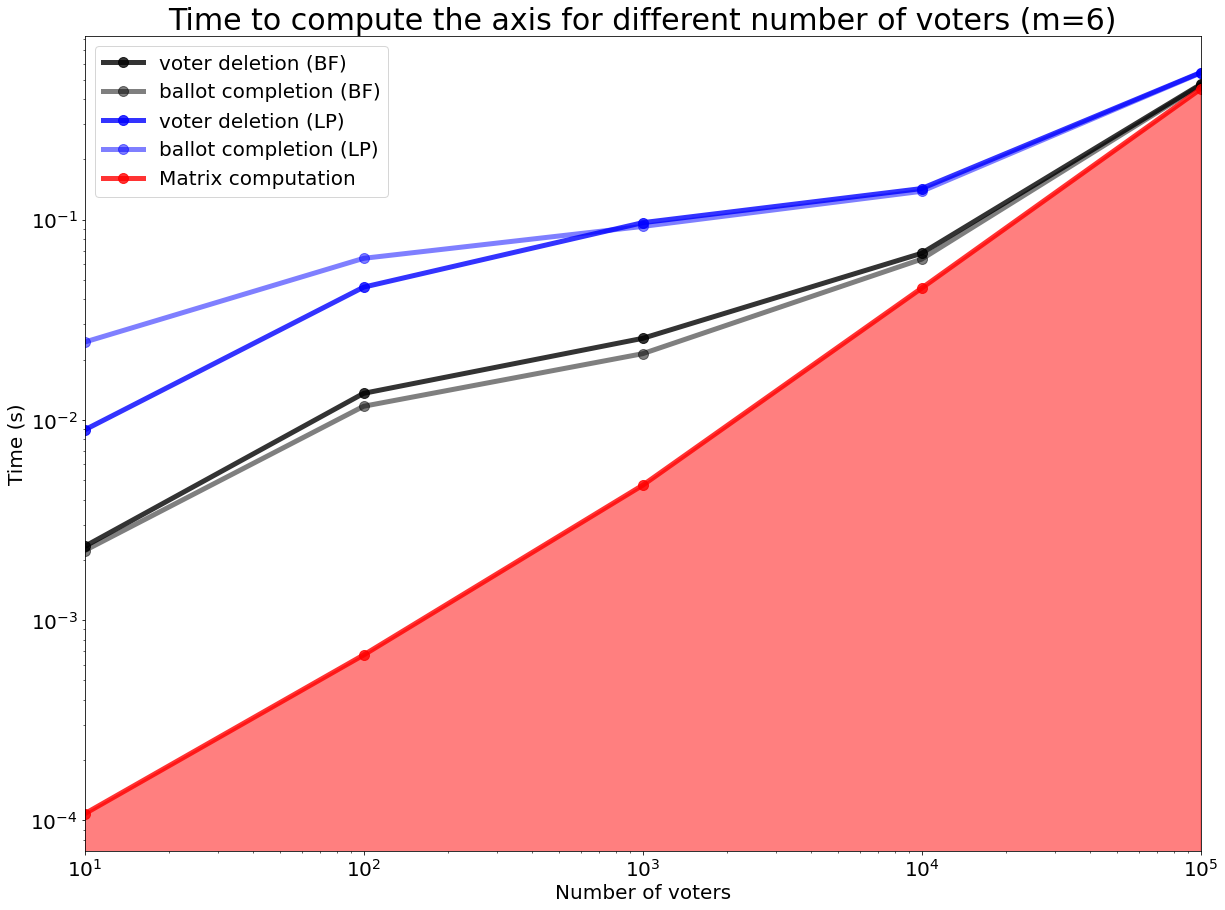

In [42]:
fig = plt.figure(figsize=(20,15))

plt.plot(n_voters_tested, time_tab[:,0], "o-", label="voter deletion (BF)", linewidth=5, color="k", alpha=0.8, markersize=10)
plt.plot(n_voters_tested, time_tab[:,1], "o-", label="ballot completion (BF)", linewidth=5, color="k", alpha=0.5,  markersize=10)
plt.plot(n_voters_tested, time_tab[:,2], "o-", label="voter deletion (LP)", linewidth=5, color="b", alpha=0.8,  markersize=10)
plt.plot(n_voters_tested, time_tab[:,3], "o-", label="ballot completion (LP)", linewidth=5, color="b", alpha=0.5,  markersize=10)
plt.plot(n_voters_tested, time_tab[:,4], "o-", label="Matrix computation", linewidth=5, color="r", alpha=0.8,  markersize=10)
plt.fill_between(n_voters_tested, 0, time_tab[:,4], color="r", alpha=0.5)

plt.xlim(10,10**5)

plt.legend(fontsize=20)

plt.xlabel("Number of voters", fontsize=20)
plt.ylabel("Time (s)", fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale("log")
plt.xscale("log")
plt.title("Time to compute the axis for different number of voters (m=6)", fontsize=30)

plt.savefig("axis/figs/time_to_compute_axis_n.png")
tikzplotlib.save("axis/figs/time_to_compute_axis_n.tex")
plt.show()


on constate que pour les deux stratégies (LP et BF), la partie qui prend le plus de temps, et dont la complexité augmente, est le pre-processing, qui consiste à convertir la matrice de votes par approbation en matrice réduite. La partie de résolution a proprement parler n'est pas beaucoup plus longue lorsque le nombre de votants augmente. C'est logique : le nombre de votants augmente, mais le nombre de bulletins différents n'augmente pas autant.

En revanche, on risque d'avoir des résultats bien différents lorsque l'on fixe le nombre de votants (par exemple à $1000$) et que le nombre de candidats augmente.

In [43]:
m_candidates_tested = range(5,10)
n_voters = 1000
n_trys = 10
time_tab = np.zeros((len(m_candidates_tested), 5))
for i, m_candidates in tqdm(enumerate(m_candidates_tested)):
    for j in (range(n_trys)):
        approval,_,_ = ax.generate_profile(m_candidates, n_voters, alpha=2, beta=0.5)
        
        start = time.time()
        _ = ax.get_axis(approval, ax.voter_deletion)
        end = time.time()
        time_tab[i,0] += end-start

        start = time.time()
        _ = ax.get_axis(approval, ax.ballot_completion)
        end = time.time()
        time_tab[i,1] += end-start

        
        start = time.time()
        _ = ax.solve_lp(approval, ax.voter_deletion_lp)
        end = time.time()
        time_tab[i,2] += end-start

        start = time.time()
        _ = ax.solve_lp(approval, ax.ballot_completion_lp)
        end = time.time()
        time_tab[i,3] += end-start

        start = time.time()
        _ = ax.compute_weighted_matrix(approval, approval.shape[1])
        end = time.time()
        time_tab[i,4] += end-start

time_tab /= n_trys

5it [24:26, 293.25s/it]


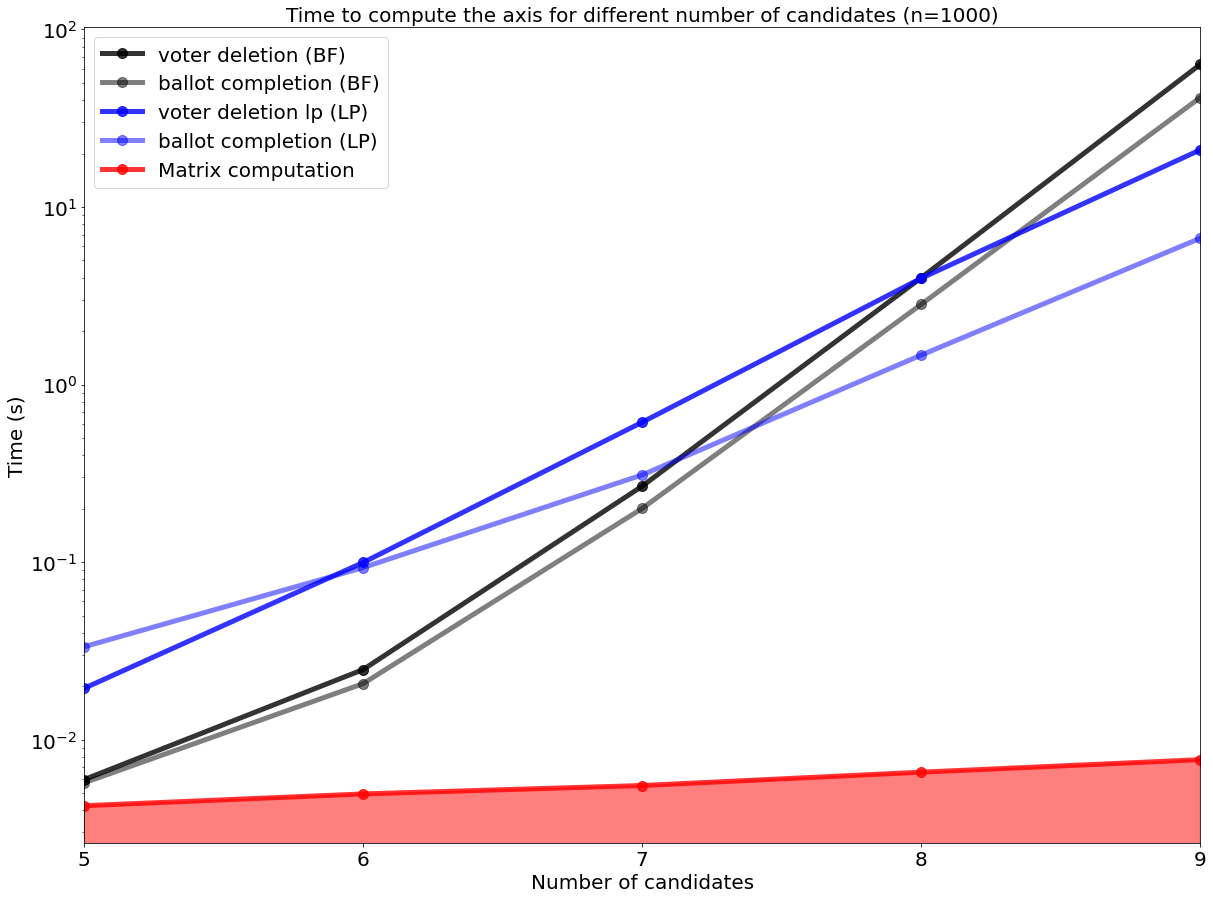

In [44]:
fig = plt.figure(figsize=(20,15))

plt.plot(m_candidates_tested, time_tab[:,0], "o-", label="voter deletion (BF)", linewidth=5, color="k", alpha=0.8, markersize=10)
plt.plot(m_candidates_tested, time_tab[:,1], "o-", label="ballot completion (BF)", linewidth=5, color="k", alpha=0.5,  markersize=10)
plt.plot(m_candidates_tested, time_tab[:,2], "o-", label="voter deletion (LP)", linewidth=5, color="b", alpha=0.8,  markersize=10)
plt.plot(m_candidates_tested, time_tab[:,3], "o-", label="ballot completion (LP)", linewidth=5, color="b", alpha=0.5,  markersize=10)
plt.plot(m_candidates_tested, time_tab[:,4], "o-", label="Matrix computation", linewidth=5, color="r", alpha=0.8,  markersize=10)
plt.fill_between(m_candidates_tested, 0, time_tab[:,4], color="r", alpha=0.5)

plt.xlim(5,9)

plt.legend(fontsize=20)

plt.xlabel("Number of candidates", fontsize=20)
plt.ylabel("Time (s)", fontsize=20)

plt.xticks(range(5,10), range(5,10), fontsize=20)
plt.yticks(fontsize=20)

plt.yscale("log")
plt.title("Time to compute the axis for different number of candidates (n=1000)", fontsize=20)
plt.savefig("axis/figs/time_to_compute_axis_m.png")
tikzplotlib.save("axis/figs/time_to_compute_axis_m.tex")
plt.show()

In [ ]:

def run_simu(m, n, alpha, beta, iter=100):
    distrib_size = np.zeros(m)
    kt_vd_tab = []
    kt_bc_tab = []

    for _ in tqdm(range(iter)):
        ballots, axis, influence = (generate_profile(m, n,alpha,beta))
        ranking_vd = solve(ballots, voter_deletion)
        ranking_bc = solve(ballots, ballot_completion)
        axis = [int(axis[i]) for i in range(m)]
        kt_vd = min(kandallTau(ranking_vd, axis), kandallTau(ranking_vd, axis[::-1]))
        kt_bc = min(kandallTau(ranking_bc, axis), kandallTau(ranking_bc, axis[::-1]))
        kt_vd_tab.append(kt_vd)
        kt_bc_tab.append(kt_bc)

        # if axis == ranking_vd or axis == ranking_vd[::-1]:
        #     c_vd += 1
        # if axis == ranking_bc or axis == ranking_bc[::-1]:
        #     c_bc += 1

        distrib_size += ([len([np.sum(x) == i for x in ballots.sum(1)]) for i in range(m)])
    return kt_vd_tab, kt_bc_tab, distrib_size/iter

m = 6
n = 1000
alpha= 5
beta = 0
iter = 100

kt_vd_tab, kt_bc_tab, distrib_size = run_simu(m, n, alpha, beta, iter)
print(distrib_size)
print(np.mean(kt_vd_tab))
print(np.mean(kt_bc_tab))
print(len([x for x in kt_vd_tab if x == 0]))
print(len([x for x in kt_bc_tab if x == 0]))